---

In [1]:
import torch
import glob
import matplotlib.pyplot as plt
import seaborn as sns

import pickle

import sys
sys.path.append("/home/twhit/mcmcdet/")

from smcdet.metrics import match_catalogs, compute_precision_recall_f1
from utils.sdss import convert_nmgy_to_mag, convert_mag_to_nmgy

---

### **Load in images, true catalogs, and MCMC results**

In [2]:
results_path = "/data/scratch/twhit/smcdet_results/m71/"
num_batches = len(glob.glob(results_path + "mcmc/counts_*.pt"))
batch_size = 10
num_images = num_batches * batch_size

prior_min_objects = 10
prior_max_objects = 10
num_catalogs = 10000

images = torch.load('../data/tiles.pt')[:num_images]
pruned_counts = torch.load('../data/pruned_counts_magcut.pt')[:num_images].int()
pruned_locs = torch.load('../data/pruned_locs_magcut.pt')[:num_images]
pruned_fluxes = torch.load('../data/pruned_fluxes_magcut.pt')[:num_images]

mcmc_unpruned_counts = torch.zeros([num_batches, batch_size, num_catalogs])
mcmc_unpruned_locs = torch.zeros([num_batches, batch_size, num_catalogs, prior_max_objects, 2])
mcmc_unpruned_fluxes = torch.zeros([num_batches, batch_size, num_catalogs, prior_max_objects])
mcmc_posterior_predictive_total_flux = torch.zeros([num_batches, batch_size, num_catalogs])
mcmc_runtime = torch.zeros([num_batches, batch_size])

for b in range(num_batches):
    mcmc_unpruned_counts[b] = torch.load(results_path + f'mcmc/counts_{b}.pt')
    mcmc_unpruned_locs[b] = torch.load(results_path + f'mcmc/locs_{b}.pt')
    mcmc_unpruned_fluxes[b] = torch.load(results_path + f'mcmc/fluxes_{b}.pt')
    mcmc_posterior_predictive_total_flux[b] = torch.load(results_path + f'mcmc/posterior_predictive_total_flux_{b}.pt')
    mcmc_runtime[b] = torch.load(results_path + f'mcmc/runtime_{b}.pt')

mcmc_unpruned_counts = mcmc_unpruned_counts.flatten(0,1).int()
mcmc_unpruned_locs = mcmc_unpruned_locs.flatten(0,1)
mcmc_unpruned_fluxes = mcmc_unpruned_fluxes.flatten(0,1)
mcmc_posterior_predictive_total_flux = mcmc_posterior_predictive_total_flux.flatten(0,1)
mcmc_runtime = mcmc_runtime.flatten(0,1)

In [3]:
with open("../data/params.pkl", "rb") as f:
    params = pickle.load(f)

In [4]:
tile_dim = 8
pad = 4

mcmc_mask = torch.logical_and(mcmc_unpruned_locs > 0, mcmc_unpruned_locs < tile_dim).all(-1)
mcmc_mask *= mcmc_unpruned_fluxes > params["flux_detection_threshold"]

mcmc_pruned_counts = mcmc_mask.sum(-1).int()

mcmc_pruned_locs = mcmc_mask.unsqueeze(-1) * mcmc_unpruned_locs
mcmc_locs_mask = (mcmc_pruned_locs != 0).int()
mcmc_locs_index = torch.sort(mcmc_locs_mask, dim=-2, descending=True)[1]
mcmc_pruned_locs = torch.gather(mcmc_pruned_locs, dim=-2, index=mcmc_locs_index)

mcmc_pruned_fluxes = mcmc_mask * mcmc_unpruned_fluxes
mcmc_fluxes_mask = (mcmc_pruned_fluxes != 0).int()
mcmc_fluxes_index = torch.sort(mcmc_fluxes_mask, dim=-1, descending=True)[1]
mcmc_pruned_fluxes = torch.gather(mcmc_pruned_fluxes, dim=-1, index=mcmc_fluxes_index)

---

### **Load in SEP results**

In [5]:
sep_unpruned_counts = torch.load(results_path + 'sep/counts.pt')[:num_images].int()
sep_unpruned_locs = torch.load(results_path + 'sep/locs.pt')[:num_images]
sep_unpruned_fluxes = torch.load(results_path + 'sep/fluxes.pt')[:num_images]
sep_runtime = torch.load(results_path + 'sep/runtime.pt')[:num_images]

In [6]:
sep_mask = torch.logical_and(sep_unpruned_locs > 0, sep_unpruned_locs < tile_dim).all(-1)
sep_mask *= sep_unpruned_fluxes > params["flux_detection_threshold"]

sep_pruned_counts = sep_mask.sum(-1)

sep_pruned_locs = sep_mask.unsqueeze(-1) * sep_unpruned_locs
sep_locs_mask = (sep_pruned_locs != 0).int()
sep_locs_index = torch.sort(sep_locs_mask, dim=-2, descending=True)[1]
sep_pruned_locs = torch.gather(sep_pruned_locs, dim=-2, index=sep_locs_index)

sep_pruned_fluxes = sep_mask * sep_unpruned_fluxes
sep_fluxes_mask = (sep_pruned_fluxes != 0).int()
sep_fluxes_index = torch.sort(sep_fluxes_mask, dim=-1, descending=True)[1]
sep_pruned_fluxes = torch.gather(sep_pruned_fluxes, dim=-1, index=sep_fluxes_index)

---

### **Plot attributes**

In [7]:
mcmc_color = "steelblue"
mcmc_marker = 'o'
sep_color = "mediumvioletred"
sep_marker = 'D'

bigfont = 20
mediumfont = 16
smallfont = 14

cmap = 'gray'

linecolor = 'sienna'
linecolor_alt = 'forestgreen'
linewidth = 4
linestyle = 'dashed'

star_marker = '*'
star_cmap = 'Wistia'
star_edge = 'black'
star_size = 400
mcmc_star_size = 0.25 * star_size
mcmc_star_alpha = 0.25

---

### **True vs. inferred magnitude distributions**

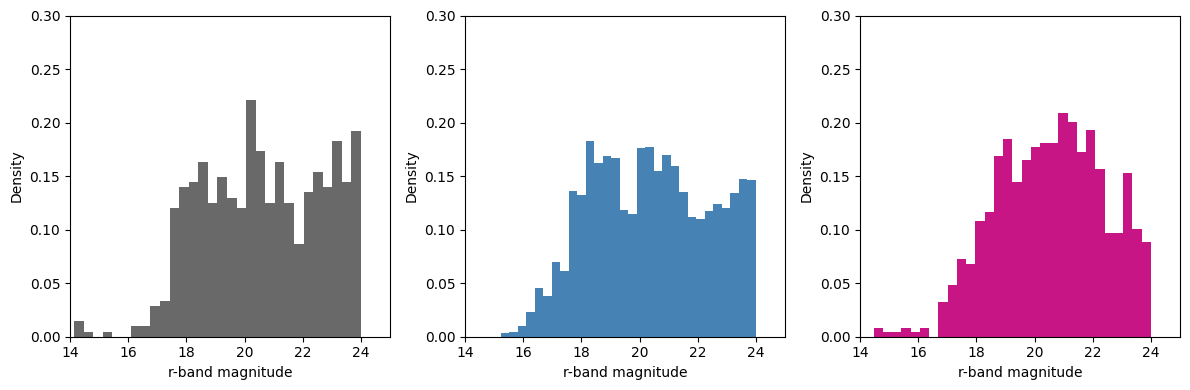

In [8]:
fig, ax = plt.subplots(1, 3, figsize = (12, 4))

_ = ax[0].hist(convert_nmgy_to_mag(pruned_fluxes[pruned_fluxes>0]),
               bins = 30, color = 'dimgray', density = True)
_ = ax[1].hist(convert_nmgy_to_mag(mcmc_pruned_fluxes[mcmc_pruned_fluxes>0][torch.randint(0, mcmc_pruned_fluxes[mcmc_pruned_fluxes>0].shape[0], size = [10000])]),
               bins = 30, color = mcmc_color, density = True)
_ = ax[2].hist(convert_nmgy_to_mag(sep_pruned_fluxes[sep_pruned_fluxes>0]),
               bins = 30, color = sep_color, density = True)

for a in ax.flat:
    _ = a.set_xlabel('r-band magnitude')
    _ = a.set_ylabel('Density')
    _ = a.set_xlim(14, 25)
    _ = a.set_ylim(0, 0.3)

_ = fig.tight_layout()

---

### **Example detections**

We write a function to plot the true catalog, one or multiple MCMC catalogs, and the SEP catalog:

In [9]:
def plot_detections(image_index, arcsinh = False,
                    mcmc_cat_idx = "all", mcmc_star_size = mcmc_star_size, mcmc_star_alpha = mcmc_star_alpha, mcmc_star_edge = False,
                    star_minflux = None, star_maxflux = None,
                    ylabel = "", title = True, ylabel_fontsize = bigfont, figsize = (18, 6)):
    fig, ax = plt.subplots(1, 3, figsize = figsize, constrained_layout = True)

    if arcsinh:
        img = images[image_index].arcsinh()
    else:
        img = images[image_index]
    
    if mcmc_cat_idx == "all":
        mcmc_cat_idx = torch.arange(0, mcmc_unpruned_counts.shape[0])
    mcmc_locs_h = mcmc_unpruned_locs[image_index, mcmc_cat_idx, :, 1]
    mcmc_locs_w = mcmc_unpruned_locs[image_index, mcmc_cat_idx, :, 0]
    mcmc_fluxes = mcmc_unpruned_fluxes[image_index,mcmc_cat_idx]
    
    if star_minflux is None:
        star_minflux = min(pruned_fluxes[image_index][pruned_fluxes[image_index]>0].min().cpu(),
                           mcmc_unpruned_fluxes.squeeze()[image_index][mcmc_unpruned_fluxes.squeeze()[image_index]>0].quantile(0.05).cpu())
    if star_maxflux is None:
        star_maxflux = min(pruned_fluxes[image_index][pruned_fluxes[image_index]>0].max().cpu(),
                           mcmc_unpruned_fluxes.squeeze()[image_index][mcmc_unpruned_fluxes.squeeze()[image_index]>0].quantile(0.95).cpu())
    
    # true catalog
    _ = ax[0].imshow(img, cmap = cmap)
    if title:
        _ = ax[0].set_title("True catalog", fontsize = ylabel_fontsize)
    else:
        _ = ax[0].set_title("", fontsize = ylabel_fontsize)

    _ = ax[0].set_ylabel(ylabel, fontsize = ylabel_fontsize)
        
    flux_cbar = ax[0].scatter(pruned_locs[image_index, :pruned_counts[image_index], 1] - 0.5,
                            pruned_locs[image_index, :pruned_counts[image_index], 0] - 0.5,
                            c = pruned_fluxes[image_index, :pruned_counts[image_index]],
                            vmin = star_minflux, vmax = star_maxflux,
                            cmap = star_cmap, edgecolors = star_edge, marker = star_marker, s = star_size)
    _ = ax[0].spines[['top', 'right', 'bottom', 'left']].set_visible(False)
    _ = ax[0].set_xticks([])
    _ = ax[0].set_yticks([])
    _ = ax[0].hlines(y = [0 - pad - 0.5, tile_dim + pad - 0.5],
                    xmin = 0 - pad - 0.5, xmax = tile_dim + pad - 0.5,
                    color = linecolor, linestyles = linestyle, linewidth = linewidth, alpha = 0)
    _ = ax[0].vlines(x = [0 - pad - 0.5, tile_dim + pad - 0.5],
                    ymin = 0 - pad - 0.5, ymax = tile_dim + pad - 0.5,
                    color = linecolor, linestyles = linestyle, linewidth = linewidth, alpha = 0)

    # MCMC catalogs
    _ = ax[1].imshow(img, cmap = cmap)
    if title:
        _ = ax[1].set_title("MCMC", fontsize = ylabel_fontsize)
    else:
        _ = ax[1].set_title("", fontsize = ylabel_fontsize)
    
    _ = ax[1].scatter(mcmc_locs_h[mcmc_locs_h.nonzero(as_tuple=True)] - 0.5,
                    mcmc_locs_w[mcmc_locs_w.nonzero(as_tuple=True)] - 0.5,
                    c = mcmc_fluxes[mcmc_fluxes.nonzero(as_tuple=True)], cmap = star_cmap,
                    vmin = star_minflux, vmax = star_maxflux,
                    marker = star_marker, s = mcmc_star_size, alpha = mcmc_star_alpha, edgecolors = star_edge if mcmc_star_edge else None)
    _ = ax[1].spines[['top', 'right', 'bottom', 'left']].set_visible(False)
    _ = ax[1].set_xticks([])
    _ = ax[1].set_yticks([])
    _ = ax[1].hlines(y = [0 - pad - 0.5, tile_dim + pad - 0.5],
                    xmin = 0 - pad - 0.5, xmax = tile_dim + pad - 0.5,
                    color = linecolor, linestyles = linestyle, linewidth = linewidth, alpha = 0)
    _ = ax[1].vlines(x = [0 - pad - 0.5, tile_dim + pad - 0.5],
                    ymin = 0 - pad - 0.5, ymax = tile_dim + pad - 0.5,
                    color = linecolor, linestyles = linestyle, linewidth = linewidth, alpha = 0)

    # SEP catalog
    _ = ax[2].imshow(img, cmap = cmap)
    if title:
        _ = ax[2].set_title("Source Extractor", fontsize = ylabel_fontsize)
    else:
        _ = ax[2].set_title("", fontsize = ylabel_fontsize)

    _ = ax[2].scatter(sep_unpruned_locs[image_index, :sep_unpruned_counts[image_index], 1] - 0.5,
                      sep_unpruned_locs[image_index, :sep_unpruned_counts[image_index], 0] - 0.5,
                      c = sep_unpruned_fluxes[image_index, :sep_unpruned_counts[image_index]],
                      vmin = star_minflux, vmax = star_maxflux,
                      cmap = star_cmap, edgecolors = star_edge, marker = star_marker, s = star_size)
    _ = ax[2].spines[['top', 'right', 'bottom', 'left']].set_visible(False)
    _ = ax[2].set_xticks([])
    _ = ax[2].set_yticks([])
    _ = ax[2].hlines(y = [0 - pad - 0.5, tile_dim + pad - 0.5],
                    xmin = 0 - pad - 0.5, xmax = tile_dim + pad - 0.5,
                    color = linecolor, linestyles = linestyle, linewidth = linewidth, alpha = 0)
    _ = ax[2].vlines(x = [0 - pad - 0.5, tile_dim + pad - 0.5],
                    ymin = 0 - pad - 0.5, ymax = tile_dim + pad - 0.5,
                    color = linecolor, linestyles = linestyle, linewidth = linewidth, alpha = 0)

    cbar = fig.colorbar(flux_cbar, ax=ax, orientation='vertical', fraction = 0.014, pad = 0.02)
    cbar.ax.tick_params(labelsize = 0.75 * ylabel_fontsize)
    
    return fig

We compare the true catalog, our ensemble of MCMC catalogs, and the SEP catalog for an image with one star, an image with two stars, with three stars, four stars, and five:

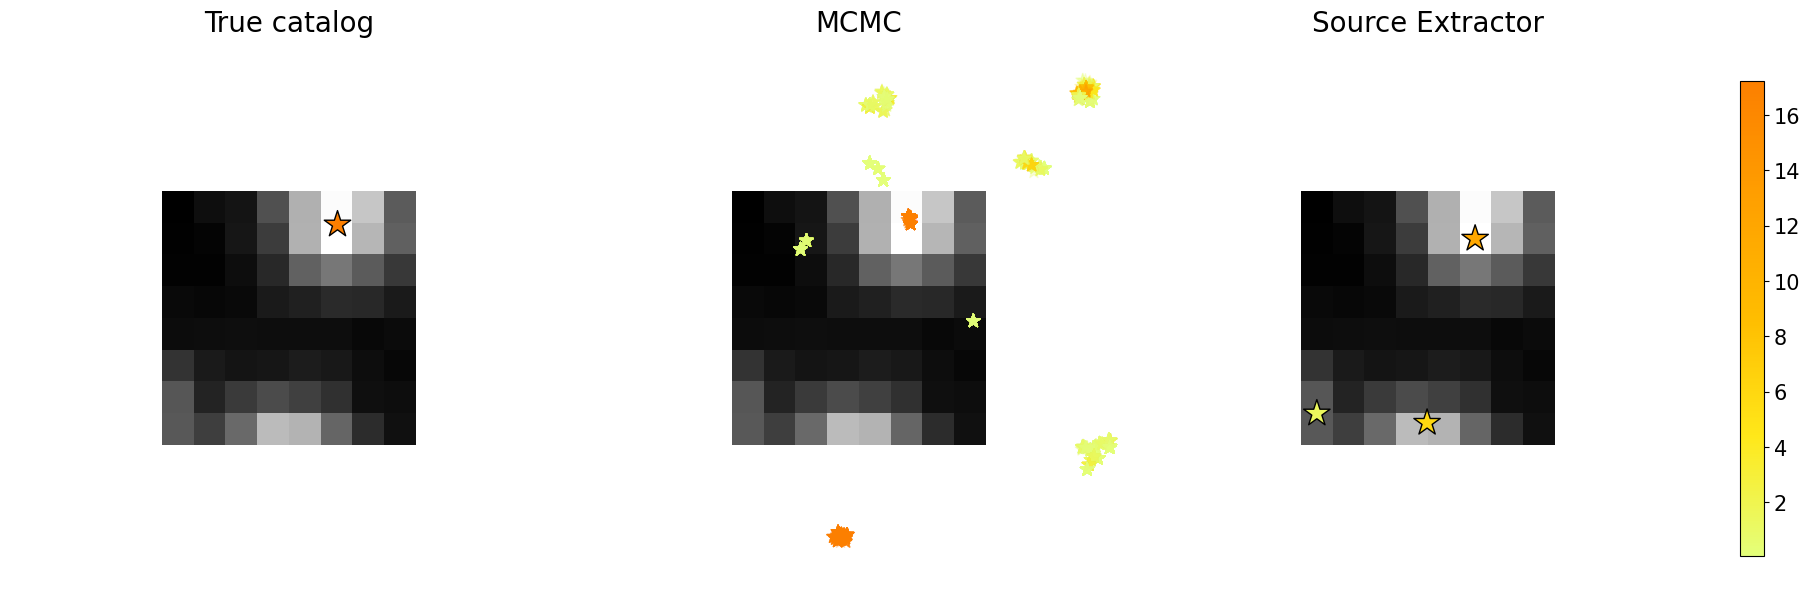

In [10]:
idx = 74

fig = plot_detections(image_index = idx, mcmc_cat_idx = "all",
                      mcmc_star_size = mcmc_star_size, mcmc_star_alpha = mcmc_star_alpha)

#fig.savefig('figures/m71_detections_count1_all.png', dpi = 250, transparent = True, bbox_inches = 'tight', pad_inches = 0)

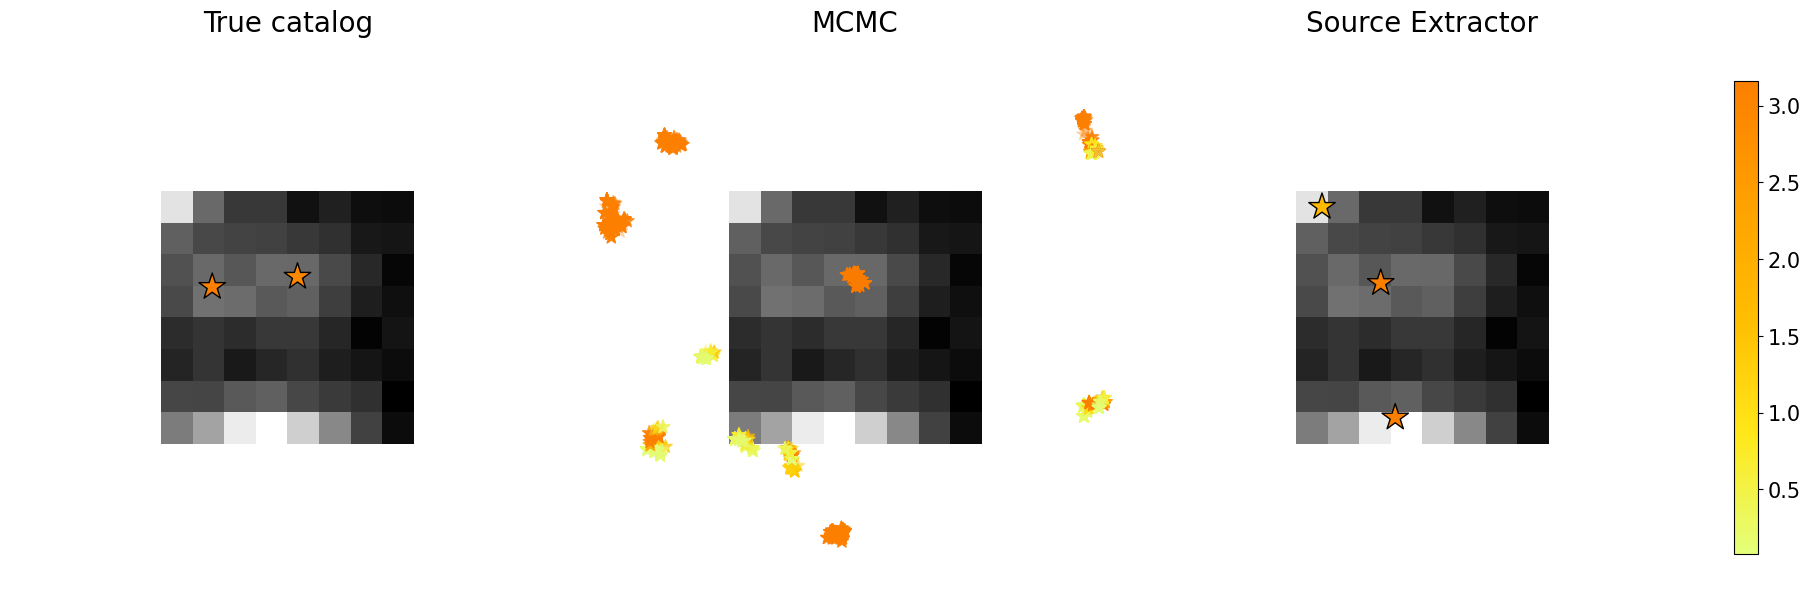

In [11]:
idx = 42

fig = plot_detections(image_index = idx, mcmc_cat_idx = "all",
                      mcmc_star_size = mcmc_star_size, mcmc_star_alpha = mcmc_star_alpha)

#fig.savefig('figures/m71_detections_count2_all.png', dpi = 250, transparent = True, bbox_inches = 'tight', pad_inches = 0)

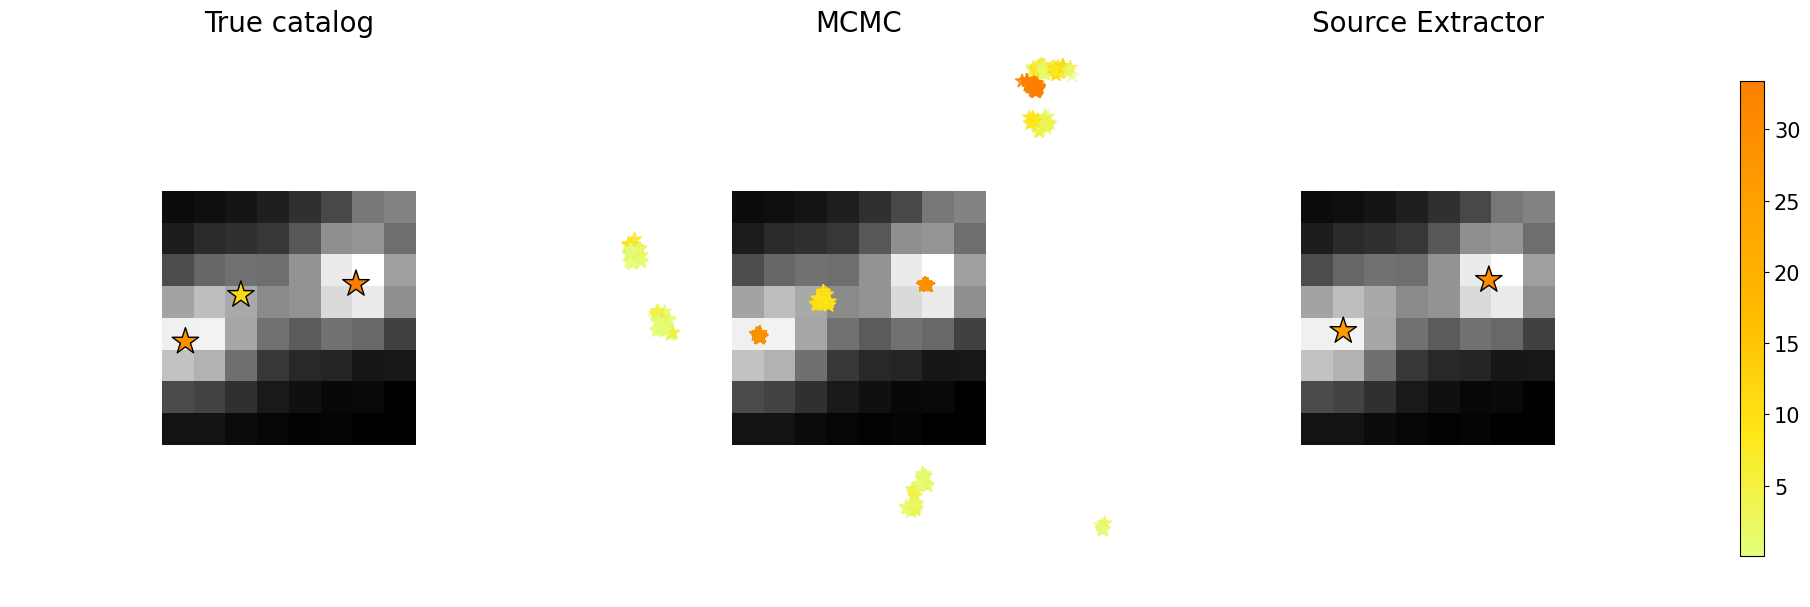

In [12]:
idx = 297

fig = plot_detections(image_index = idx, mcmc_cat_idx = "all",
                      mcmc_star_size = mcmc_star_size, mcmc_star_alpha = mcmc_star_alpha)

#fig.savefig('figures/m71_detections_count3_all.png', dpi = 250, transparent = True, bbox_inches = 'tight', pad_inches = 0)

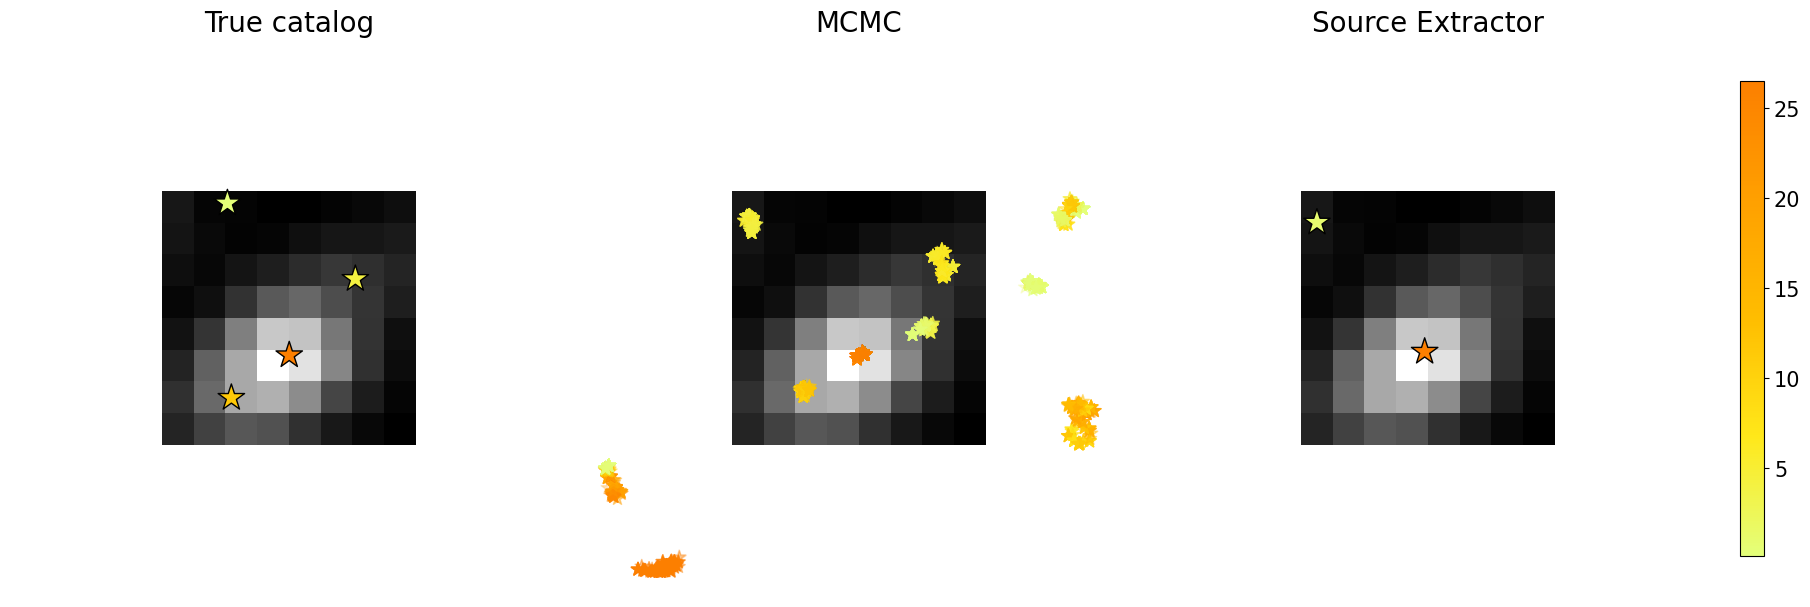

In [13]:
idx = 148

fig = plot_detections(image_index = idx, mcmc_cat_idx = "all",
                      mcmc_star_size = mcmc_star_size, mcmc_star_alpha = mcmc_star_alpha)

#fig.savefig('figures/m71_detections_count4_all.png', dpi = 250, transparent = True, bbox_inches = 'tight', pad_inches = 0)

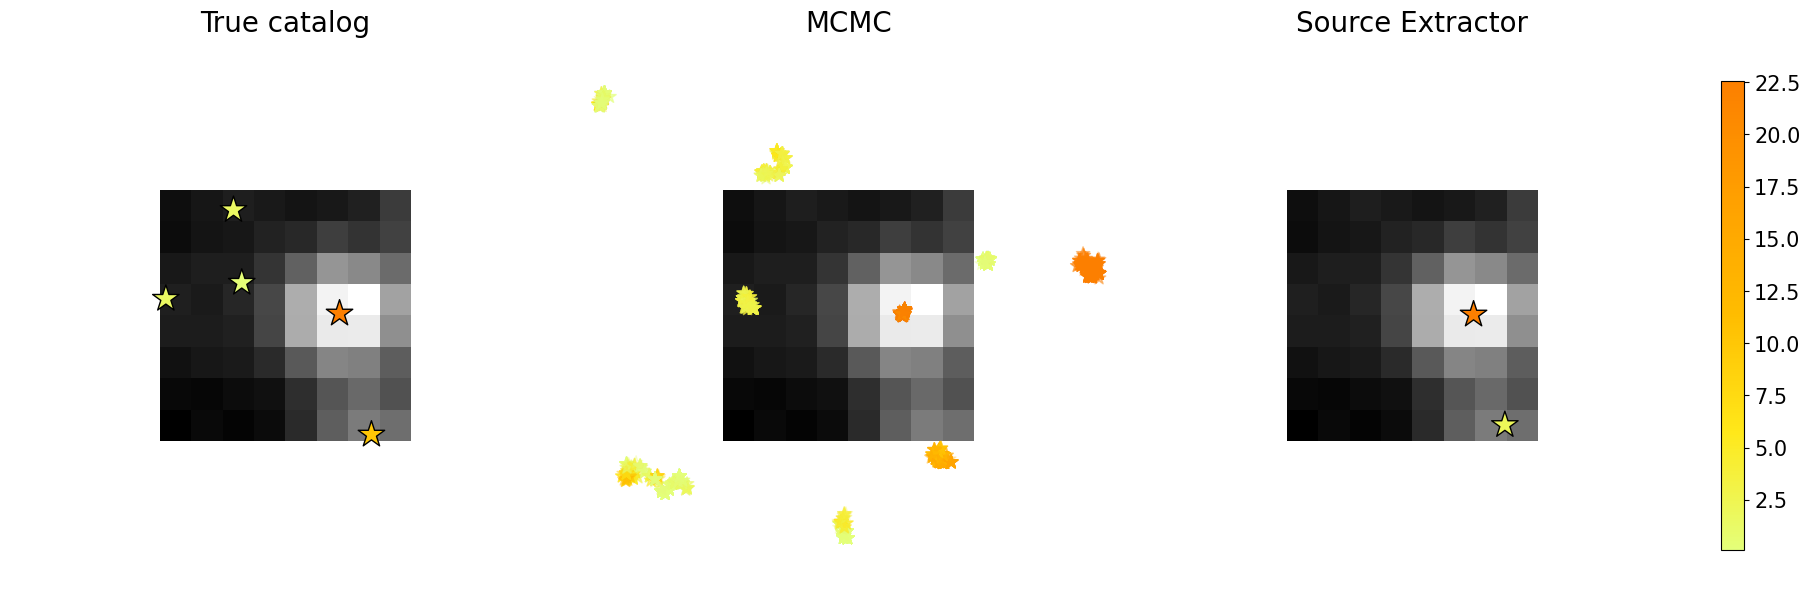

In [14]:
idx = 320

fig = plot_detections(image_index = idx, mcmc_cat_idx = "all",
                      mcmc_star_size = mcmc_star_size, mcmc_star_alpha = mcmc_star_alpha)

#fig.savefig('figures/m71_detections_count5_all.png', dpi = 250, transparent = True, bbox_inches = 'tight', pad_inches = 0)

---

### **Source count heat maps**

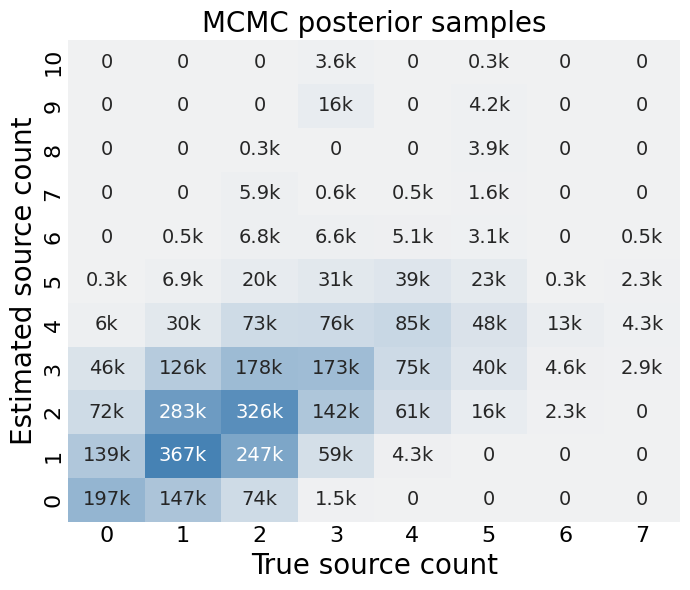

In [15]:
torch.manual_seed(0)

confmat_magcut = torch.tensor(24.0)
confmat_fluxcut = convert_mag_to_nmgy(confmat_magcut)

confmat_mcmc_sampled_counts = ((mcmc_pruned_fluxes != 0) & (mcmc_pruned_fluxes >= confmat_fluxcut)).sum(-1)
confmat_true_counts = ((pruned_fluxes != 0) & (pruned_fluxes >= confmat_fluxcut)).sum(-1).unsqueeze(-1).repeat(1, mcmc_pruned_counts.shape[-1])

mcmc_samples_confmat = torch.histogramdd(
    torch.stack((confmat_mcmc_sampled_counts, confmat_true_counts), dim=-1).float(),
    bins = (torch.arange(0, mcmc_pruned_counts.max() + 2).float(), torch.arange(0, pruned_counts.max() + 2).unique().float())
).hist

fig, ax = plt.subplots(1, 1, figsize = (7, 6))

panel = sns.heatmap(mcmc_samples_confmat.int().numpy(),
                    ax = ax, annot = True, annot_kws={"size": smallfont}, fmt = "d",
                    cmap = sns.light_palette(mcmc_color, as_cmap=True), cbar = False)
panel.invert_yaxis()

def format_func(value, tick_position):
    if value >= 100000:
        return f"{round(value / 1000, 1):.0f}k"
    if value >= 50:
        return f"{round(value / 1000, 1):.2g}k"
    return str("0")

for text in panel.texts:
    value = int(text.get_text())
    text.set_text(format_func(value, None))

panel.set_xlabel("True source count", fontsize = bigfont)
panel.set_ylabel("Estimated source count", fontsize = bigfont)
panel.tick_params(axis = 'both', length = 0, labelsize = mediumfont)

_ = ax.set_title("MCMC posterior samples", fontsize = bigfont)

fig.tight_layout()

#fig.savefig('figures/m71_confmat_mcmc_samples.png', dpi = 250, transparent = True, bbox_inches = 'tight', pad_inches = 0)

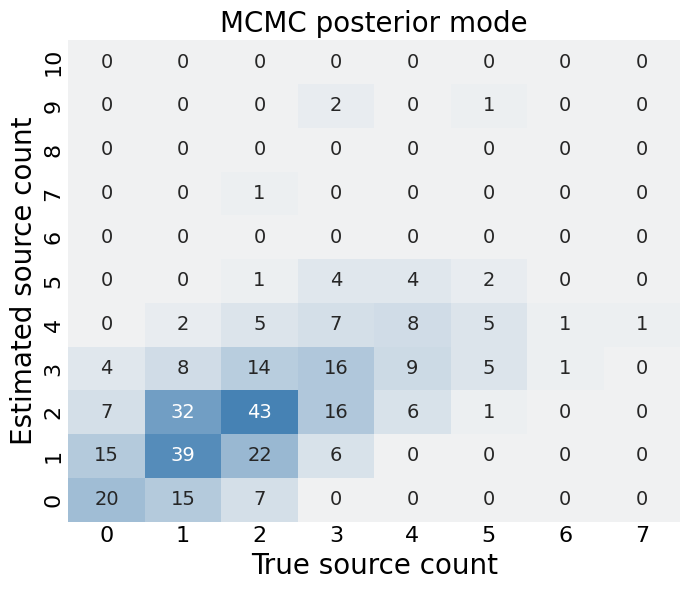

In [16]:
confmat_mcmc_mode_counts = ((mcmc_pruned_fluxes != 0) & (mcmc_pruned_fluxes >= confmat_fluxcut)).sum(-1).mode(-1).values
confmat_true_counts = ((pruned_fluxes != 0) & (pruned_fluxes >= confmat_fluxcut)).sum(-1)

mcmc_samples_confmat = torch.histogramdd(
    torch.stack((confmat_mcmc_mode_counts, confmat_true_counts), dim=-1).float(),
    bins = (torch.arange(0, mcmc_pruned_counts.max() + 2).float(), torch.arange(0, pruned_counts.max() + 2).unique().float())
).hist

fig, ax = plt.subplots(1, 1, figsize = (7, 6))

panel = sns.heatmap(mcmc_samples_confmat.int().numpy(),
                    ax = ax, annot = True, annot_kws={"size": smallfont}, fmt = "d",
                    cmap = sns.light_palette(mcmc_color, as_cmap=True), cbar = False)
panel.invert_yaxis()

panel.set_xlabel("True source count", fontsize = bigfont)
panel.set_ylabel("Estimated source count", fontsize = bigfont)
panel.tick_params(axis = 'both', length = 0, labelsize = mediumfont)

_ = ax.set_title("MCMC posterior mode", fontsize = bigfont)

fig.tight_layout()

#fig.savefig('figures/m71_confmat_mcmc_mode.png', dpi = 250, transparent = True, bbox_inches = 'tight', pad_inches = 0)

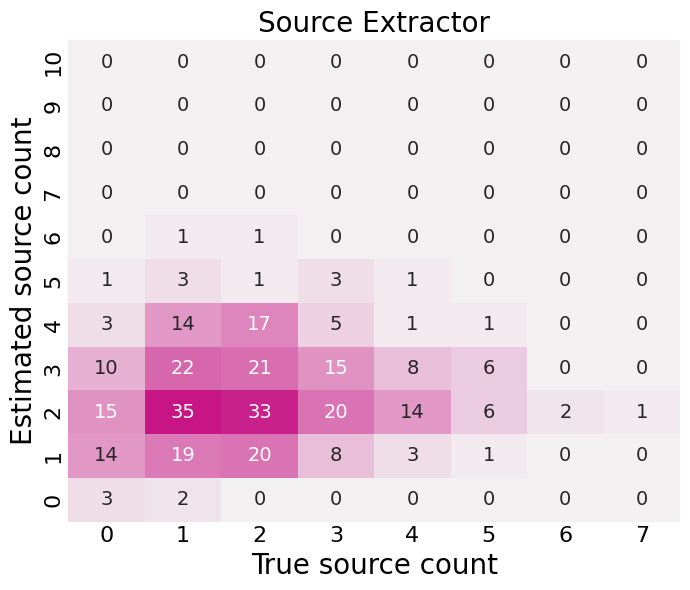

In [17]:
confmat_sep_counts = ((sep_pruned_fluxes != 0) & (sep_pruned_fluxes >= confmat_fluxcut)).sum(-1)

sep_confmat = torch.histogramdd(
    torch.stack((confmat_sep_counts, confmat_true_counts), dim=-1).float(),
    bins = (torch.arange(0, mcmc_pruned_counts.max() + 2).float(), torch.arange(0, pruned_counts.max() + 2).unique().float())
).hist

fig, ax = plt.subplots(1, 1, figsize = (7, 6))
panel = sns.heatmap(sep_confmat.int().numpy(),
                    ax = ax, annot = True, annot_kws={"size": smallfont}, fmt = "d",
                    cmap = sns.light_palette(sep_color, as_cmap=True), cbar = False)
panel.invert_yaxis()

panel.set_xlabel("True source count", fontsize = bigfont)
panel.set_ylabel("Estimated source count", fontsize = bigfont)
panel.tick_params(axis = 'both', length = 0, labelsize = mediumfont)

_ = ax.set_title("Source Extractor", fontsize = bigfont)

fig.tight_layout()

#fig.savefig('figures/m71_confmat_sep.png', dpi = 250, transparent = True, bbox_inches = 'tight', pad_inches = 0)

---

### **Calibration of total intrinsic flux**

We compute and plot the empirical coverage rate of x% credible intervals formed using CS-MCMC samples for $x \in [0.05,...,0.95]$

In [18]:
intervals = [c*0.05 for c in range(1,20)]
coverage_rate = []

mcmc_masked_tif = mcmc_pruned_fluxes[pruned_counts>0].sum(-1)
masked_tif = pruned_fluxes[pruned_counts>0].sum(-1)

for i in intervals:
    qlow = mcmc_masked_tif.quantile(0.5 - i / 2, dim = -1)
    qhigh = mcmc_masked_tif.quantile(0.5 + i / 2, dim = -1)
    covered = torch.logical_and(qlow <= masked_tif, qhigh >= masked_tif)
    
    coverage_rate.append(covered.float().mean())

[(f"nominal coverage probability = {round(i,2)}, empirical coverage probability = {round(r.item(),2)}") for (i,r) in zip(intervals, coverage_rate)]

['nominal coverage probability = 0.05, empirical coverage probability = 0.04',
 'nominal coverage probability = 0.1, empirical coverage probability = 0.08',
 'nominal coverage probability = 0.15, empirical coverage probability = 0.1',
 'nominal coverage probability = 0.2, empirical coverage probability = 0.13',
 'nominal coverage probability = 0.25, empirical coverage probability = 0.15',
 'nominal coverage probability = 0.3, empirical coverage probability = 0.17',
 'nominal coverage probability = 0.35, empirical coverage probability = 0.2',
 'nominal coverage probability = 0.4, empirical coverage probability = 0.24',
 'nominal coverage probability = 0.45, empirical coverage probability = 0.27',
 'nominal coverage probability = 0.5, empirical coverage probability = 0.3',
 'nominal coverage probability = 0.55, empirical coverage probability = 0.33',
 'nominal coverage probability = 0.6, empirical coverage probability = 0.36',
 'nominal coverage probability = 0.65, empirical coverage pro

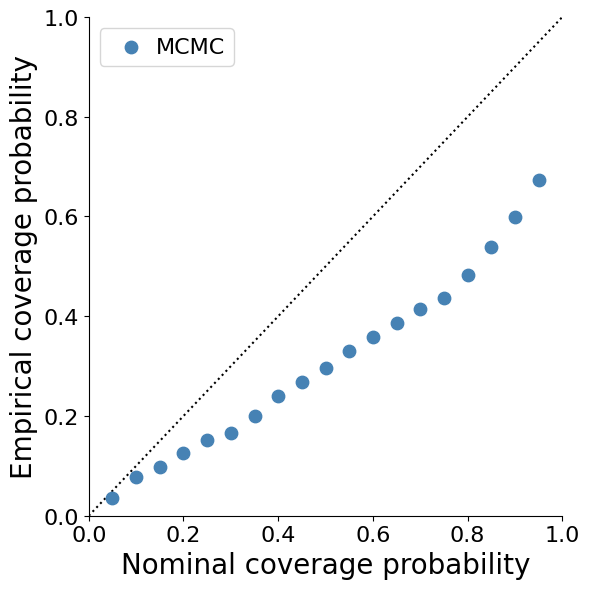

In [19]:
fig, ax = plt.subplots(1, 1, figsize = (6, 6))

_ = ax.axline((0,0), slope = 1, linestyle = ':', color = 'black', zorder = 0)
_ = ax.scatter(intervals, coverage_rate, label = 'MCMC',
               color = mcmc_color, marker = mcmc_marker, s = 80, zorder = 1)

_ = ax.set_xlim((0,1))
_ = ax.set_ylim((0,1))

_ = ax.set_xlabel('Nominal coverage probability', fontsize = bigfont)
_ = ax.set_ylabel('Empirical coverage probability', fontsize = bigfont)

_ = ax.tick_params(axis = 'both', labelsize = mediumfont)

_ = ax.legend(loc = 'upper left', prop = {'size': mediumfont}, handletextpad = 0.1)

_ = ax.spines[['top', 'right']].set_visible(False)

fig.tight_layout()

#fig.savefig('figures/m71_totalflux_coverage_mcmc.png', dpi = 250, transparent = True, bbox_inches = 'tight', pad_inches = 0)

And to demonstrate this achievement of nominal coverage, we plot the 90% credible intervals for MCMC and compare them to Source Extractor's point estimates:

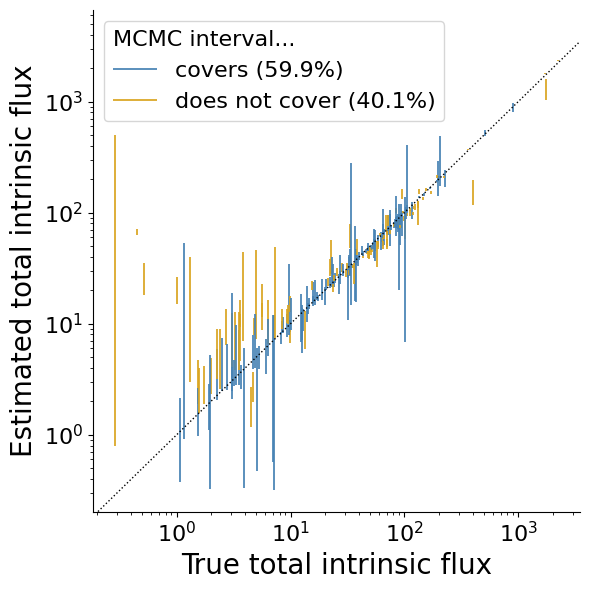

In [20]:
interval = 0.9

# mask intervals that contain zero for aesthetic purposes
mask = mcmc_pruned_fluxes.sum(-1).quantile(0.05, dim=-1) > 0

q05 = mcmc_pruned_fluxes[mask].sum(-1).quantile(0.5 - interval / 2, dim = -1)
q95 = mcmc_pruned_fluxes[mask].sum(-1).quantile(0.5 + interval / 2, dim = -1)
covered = torch.logical_and(q05 <= pruned_fluxes[mask].sum(-1),
                            q95 >= pruned_fluxes[mask].sum(-1))

fig, ax = plt.subplots(1, 1, figsize = (6, 6))

true_total_intrinsic_flux = pruned_fluxes[mask].sum(-1)

covered_legend = False
uncovered_legend = False
# to avoid one color from dominating, plot by index instead of in two groups
for i in range(pruned_fluxes[mask].shape[0]):
    color = mcmc_color if covered[i] else 'goldenrod'
    style = 'solid' if covered[i] else 'solid'
    if (covered[i]) and (not covered_legend):
        covered_legend = True
        _ = ax.vlines(x = true_total_intrinsic_flux[i],
                      ymin = q05[i], ymax = q95[i], color = color, alpha = 1, linewidth = 1.25, linestyle = style,
                      label = f"covers ({round(100 * coverage_rate[-2].item(), 1)}%)")
    elif (not covered[i]) and (not uncovered_legend):
        uncovered_legend = True
        _ = ax.vlines(x = true_total_intrinsic_flux[i],
                      ymin = q05[i], ymax = q95[i], color = color, alpha = 1, linewidth = 1.25, linestyle = style,
                      label = f"does not cover ({round(100 * (1 - coverage_rate[-2]).item(), 1)}%)")
    else:
        _ = ax.vlines(x = true_total_intrinsic_flux[i],
                    ymin = q05[i], ymax = q95[i], color = color, alpha = 1, linewidth = 1.25, linestyle = style,)

_ = ax.axline((0,0), slope = 1, color = 'black', linestyle = ':', linewidth = 1)

_ = ax.set_xscale('log')
_ = ax.set_yscale('log')
_ = ax.set_xlabel('True total intrinsic flux', fontsize = bigfont)
_ = ax.set_ylabel('Estimated total intrinsic flux', fontsize = bigfont)
_ = ax.set_ylim(ax.get_ylim()[0], 3*true_total_intrinsic_flux.max())
_ = ax.tick_params(axis = "both", labelsize = mediumfont)

_ = ax.spines[['top', 'right']].set_visible(False)

leg = ax.legend(loc = 'upper left', prop = {'size': mediumfont}, title = "MCMC interval...", title_fontsize = mediumfont)
leg._legend_box.align = 'left'

fig.tight_layout()

#fig.savefig('figures/m71_totalflux_intervals_mcmc.png', dpi = 250, transparent = True, bbox_inches = 'tight', pad_inches = 0)

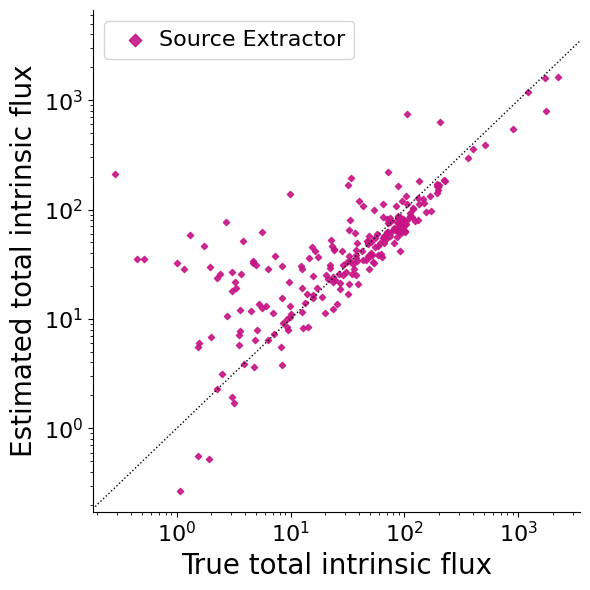

In [21]:
fig, ax = plt.subplots(1, 1, figsize = (6, 6))

# to avoid one color from dominating, plot by index instead of in two groups
_ = ax.scatter(x = pruned_fluxes[mask].sum(-1), y = sep_pruned_fluxes[mask].sum(-1),
               color = sep_color, marker = sep_marker, s = 10, alpha = 0.9, label = "Source Extractor")

_ = ax.axline((0,0), slope = 1, color = 'black', linestyle = ':', linewidth = 1)

_ = ax.set_xscale('log')
_ = ax.set_yscale('log')
_ = ax.set_xlabel('True total intrinsic flux', fontsize = bigfont)
_ = ax.set_ylabel('Estimated total intrinsic flux', fontsize = bigfont)
_ = ax.set_ylim(ax.get_ylim()[0], 3*true_total_intrinsic_flux.max())

_ = ax.tick_params(axis = "both", labelsize = mediumfont)
_ = ax.legend(loc = 'upper left', prop = {'size': mediumfont},
              handletextpad = 0.1, markerscale = 2)

_ = ax.spines[['top', 'right']].set_visible(False)

fig.tight_layout()

#fig.savefig('figures/m71_totalflux_sep.png', dpi = 250, transparent = True, bbox_inches = 'tight', pad_inches = 0)

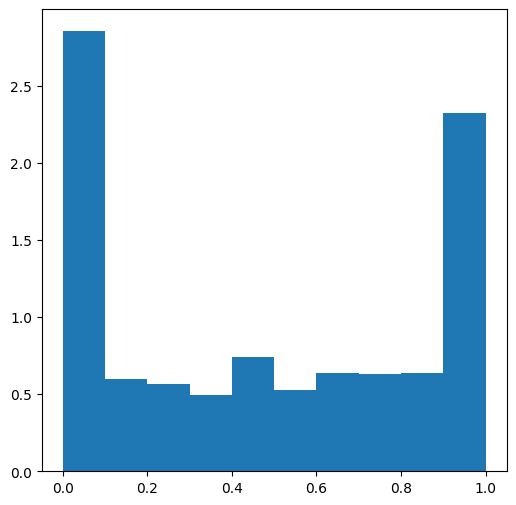

In [22]:
# simulation-based calibration plot
sbc_mh_totalfluxes = (masked_tif.unsqueeze(-1) <= mcmc_masked_tif).float().mean(-1)

fig, ax = plt.subplots(1, 1, figsize = (6, 6))
_ = ax.hist(sbc_mh_totalfluxes, bins = 10, density = True)

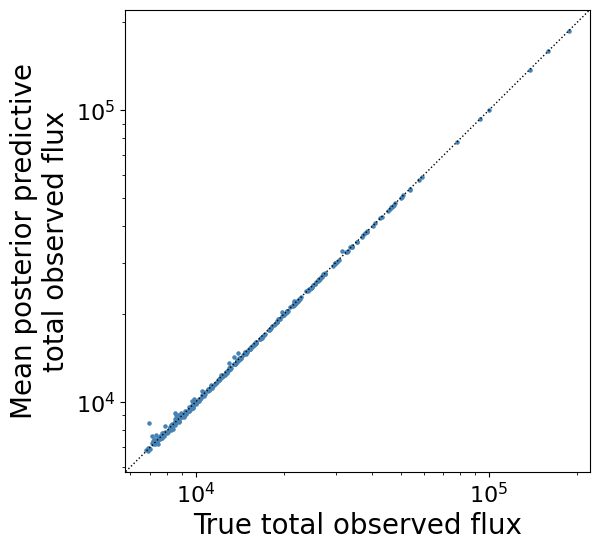

In [23]:
# true total observed flux vs mean posterior predictive total observed flux
fig, ax = plt.subplots(1, 1, figsize = (6, 6))

posterior_predictive_mask = images.sum([-1,-2]) < images.sum([-1,-2]).quantile(0.99)

_ = ax.scatter(x = images[posterior_predictive_mask].sum([-1,-2]),
               y = mcmc_posterior_predictive_total_flux[posterior_predictive_mask].mean(-1),
               color = mcmc_color, s = 5, alpha = 1, label = "CS-MCMC")

_ = ax.axline((0,0), slope = 1, color = 'black', linestyle = ':', linewidth = 1)

_ = ax.set_xscale('log')
_ = ax.set_yscale('log')

_ = ax.set_xlabel('True total observed flux', fontsize = bigfont)
_ = ax.set_ylabel('Mean posterior predictive\ntotal observed flux', fontsize = bigfont)
_ = ax.tick_params(axis = 'both', labelsize = mediumfont)

---

### **Precision, recall, and F1**

We match sources that are within half a pixel of a true source and have an r-band mag within half a unit. We use mag bins ranging from 17 to 24.

In [24]:
mag_bins = torch.arange(18.0, 24.5, 0.5)
mags_tol = 0.5
locs_tol = 0.5

In [25]:
torch.manual_seed(0)

mcmc_matching_results = match_catalogs(pruned_counts, pruned_locs, pruned_fluxes,
                                      mcmc_pruned_counts, mcmc_pruned_locs, mcmc_pruned_fluxes,
                                      200, locs_tol, mags_tol, mag_bins)
mcmc_true_total, mcmc_true_matches, mcmc_est_total, mcmc_est_matches = mcmc_matching_results

mcmc_precision, mcmc_recall, mcmc_f1 = compute_precision_recall_f1(mcmc_true_total, mcmc_true_matches, mcmc_est_total, mcmc_est_matches)

In [26]:
num_boot_samples = 10000
boot_mean_precision = torch.zeros(num_boot_samples, len(mag_bins))
boot_mean_recall = torch.zeros(num_boot_samples, len(mag_bins))
boot_mean_f1 = torch.zeros(num_boot_samples, len(mag_bins))

for b in range(num_boot_samples):
    boot_idx = torch.randint(0, mcmc_precision.shape[0], size = [mcmc_precision.shape[0]])
    boot_mean_precision[b] = mcmc_precision[boot_idx].mean(0)
    boot_mean_recall[b] = mcmc_recall[boot_idx].mean(0)
    boot_mean_f1[b] = mcmc_f1[boot_idx].mean(0)

alpha = 0.1 # 90% confidence intervals
num_multiple_comparisons = 3 * len(mag_bins) # Bonferroni correction

mcmc_precision_lower = torch.quantile(boot_mean_precision, alpha / num_multiple_comparisons, dim = 0)
mcmc_precision_mean = boot_mean_precision.mean(dim = 0)
mcmc_precision_upper = torch.quantile(boot_mean_precision, 1 - alpha / num_multiple_comparisons, dim = 0)

mcmc_recall_lower = torch.quantile(boot_mean_recall, alpha / num_multiple_comparisons, dim = 0)
mcmc_recall_mean = boot_mean_recall.mean(dim = 0)
mcmc_recall_upper = torch.quantile(boot_mean_recall, 1 - alpha / num_multiple_comparisons, dim = 0)
mcmc_f1_lower = torch.quantile(boot_mean_f1, alpha / num_multiple_comparisons, dim = 0)
mcmc_f1_mean = boot_mean_f1.mean(dim = 0)
mcmc_f1_upper = torch.quantile(boot_mean_f1, 1 - alpha / num_multiple_comparisons, dim = 0)

In [27]:
sep_matching_results = match_catalogs(pruned_counts, pruned_locs, pruned_fluxes,
                                      sep_pruned_counts.unsqueeze(1), sep_pruned_locs.unsqueeze(1), sep_pruned_fluxes.unsqueeze(1),
                                      1, locs_tol, mags_tol, mag_bins)
sep_true_total, sep_true_matches, sep_est_total, sep_est_matches = sep_matching_results

sep_precision, sep_recall, sep_f1 = compute_precision_recall_f1(sep_true_total, sep_true_matches, sep_est_total, sep_est_matches)

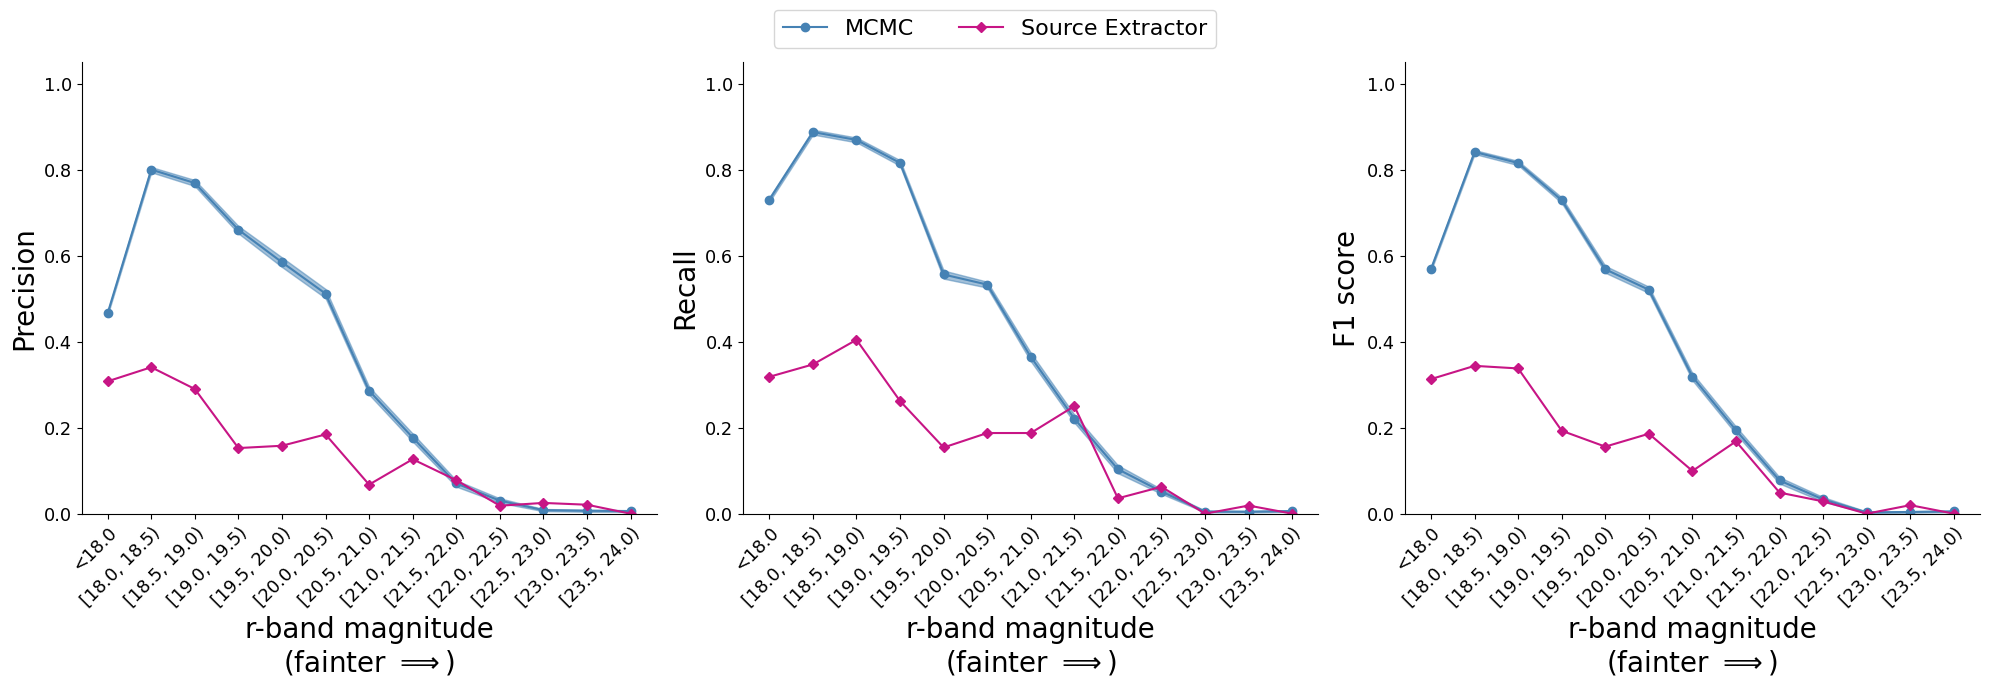

In [28]:
fig, ax = plt.subplots(1, 3, figsize = (20, 6*1.075))

ms = 6

_ = ax[0].plot(mag_bins, mcmc_precision_mean, color = mcmc_color, marker = mcmc_marker, ms = ms, label = "MCMC")
_ = ax[0].plot(mag_bins, sep_precision.squeeze(), color = sep_color, marker = sep_marker, ms = 0.9*ms, label = "Source Extractor")
_ = ax[0].fill_between(mag_bins, mcmc_precision_lower, mcmc_precision_upper, color = mcmc_color, alpha = 0.5)
_ = ax[0].set_ylabel('Precision', fontsize = bigfont)

_ = ax[1].plot(mag_bins, mcmc_recall.mean(0), color = mcmc_color, marker = mcmc_marker, ms = ms, label = "MCMC")
_ = ax[1].plot(mag_bins, sep_recall.squeeze(), color = sep_color, marker = sep_marker, ms = 0.9*ms, label = "Source Extractor")
_ = ax[1].fill_between(mag_bins, mcmc_recall_lower, mcmc_recall_upper, color = mcmc_color, alpha = 0.5)
_ = ax[1].set_ylabel('Recall', fontsize = bigfont)

_ = ax[2].plot(mag_bins, mcmc_f1_mean, color = mcmc_color, marker = mcmc_marker, ms = ms, label = "MCMC")
_ = ax[2].plot(mag_bins, sep_f1.squeeze(), color = sep_color, marker = sep_marker, ms = 0.9*ms, label = "Source Extractor")
_ = ax[2].fill_between(mag_bins, mcmc_f1_lower, mcmc_f1_upper, color = mcmc_color, alpha = 0.5)
_ = ax[2].set_ylabel('F1 score', fontsize = bigfont)

for a in ax.flat:
    _ = a.tick_params(axis = "both", labelsize = 0.8*mediumfont)
    _ = a.set_xticks(ticks = mag_bins,
                     labels = [f'<{mag_bins[0]}'] + [f'[{mag_bins[t].item()}, {mag_bins[t+1]})' for t in range(len(mag_bins)-1)],
                     rotation = 45, ha = 'right', rotation_mode = "anchor")
    _ = a.set_xlabel('r-band magnitude\n(fainter $\\Longrightarrow$)', fontsize = bigfont)
    _ = a.spines[['top', 'right']].set_visible(False)
    _ = a.set_ylim((0,1.05))

handles, labels = ax[0].get_legend_handles_labels()
_ = fig.legend(handles, labels, loc = 'upper center', ncol = 2, bbox_to_anchor = (0.5, 1.075), fontsize = mediumfont)

_ = fig.tight_layout()

#fig.savefig('figures/m71_matching.png', dpi = 250, transparent = True, bbox_inches = 'tight', pad_inches = 0)

---

### **Luminosity functions**

In [29]:
torch.manual_seed(0)

clf_mag_bins = torch.arange(18.0, 24.5, 1.0)

clf_mcmc_matches = match_catalogs(pruned_counts, pruned_locs, pruned_fluxes,
                                 mcmc_pruned_counts, mcmc_pruned_locs, mcmc_pruned_fluxes,
                                 200, locs_tol, mags_tol, clf_mag_bins)
clf_mcmc_true_total, clf_mcmc_true_matches, clf_mcmc_est_total, clf_mcmc_est_matches = clf_mcmc_matches

clf_sep_matches = match_catalogs(pruned_counts, pruned_locs, pruned_fluxes,
                                 sep_pruned_counts.unsqueeze(1), sep_pruned_locs.unsqueeze(1), sep_pruned_fluxes.unsqueeze(1),
                                 1, locs_tol, mags_tol, clf_mag_bins)
clf_sep_true_total, clf_sep_true_matches, clf_sep_est_total, clf_sep_est_matches = clf_sep_matches

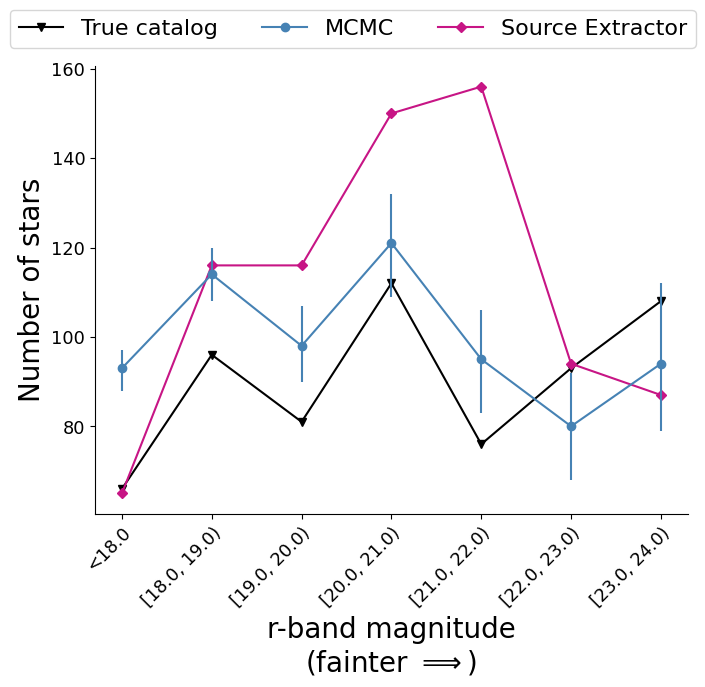

In [30]:
fig, ax = plt.subplots(1, 1, figsize = (7, 6 * 1.075))

ls = 'solid'
ms = 6

_ = ax.plot(clf_mag_bins, clf_mcmc_true_total.sum(0)[0], label = "True catalog",
            marker = "v", ms = 1.05*ms, linestyle = ls, color = 'black', zorder = 0)
_ = ax.plot(clf_mag_bins, clf_mcmc_est_total.sum(0).median(0).values, label = "MCMC",
            marker = mcmc_marker, ms = ms, linestyle = ls, color = mcmc_color, zorder = 3)
_ = ax.vlines(clf_mag_bins, ymin = clf_mcmc_est_total.sum(0).quantile(0.05, dim=0), ymax = clf_mcmc_est_total.sum(0).quantile(0.95, dim=0),
              color = mcmc_color, zorder = 2)
_ = ax.plot(clf_mag_bins, clf_sep_est_total.sum(0).permute(1, 0), label = "Source Extractor",
            marker = sep_marker, ms = 0.9*ms, color = sep_color, linestyle = ls, zorder = 1)
_ = ax.set_ylabel('Number of stars', fontsize = bigfont)

_ = ax.tick_params(axis = "both", labelsize = 0.8*mediumfont)
_ = ax.set_xticks(ticks = clf_mag_bins,
                  labels = [f'<{clf_mag_bins[0]}'] + [f'[{clf_mag_bins[t].item()}, {clf_mag_bins[t+1]})' for t in range(len(clf_mag_bins)-1)],
                  rotation = 45, ha = 'right', rotation_mode = "anchor")
_ = ax.set_xlabel('r-band magnitude\n(fainter $\\Longrightarrow$)', fontsize = bigfont)
_ = ax.spines[['top', 'right']].set_visible(False)

handles, labels = ax.get_legend_handles_labels()
_ = fig.legend(handles, labels, loc = 'upper center', ncol = 3, bbox_to_anchor = (0.5, 1.075), fontsize = mediumfont)

_ = fig.tight_layout()

#fig.savefig('figures/m71_clf.png', dpi = 250, transparent = True, bbox_inches = 'tight', pad_inches = 0)

---

### **Runtime and number of MCMC iterations**

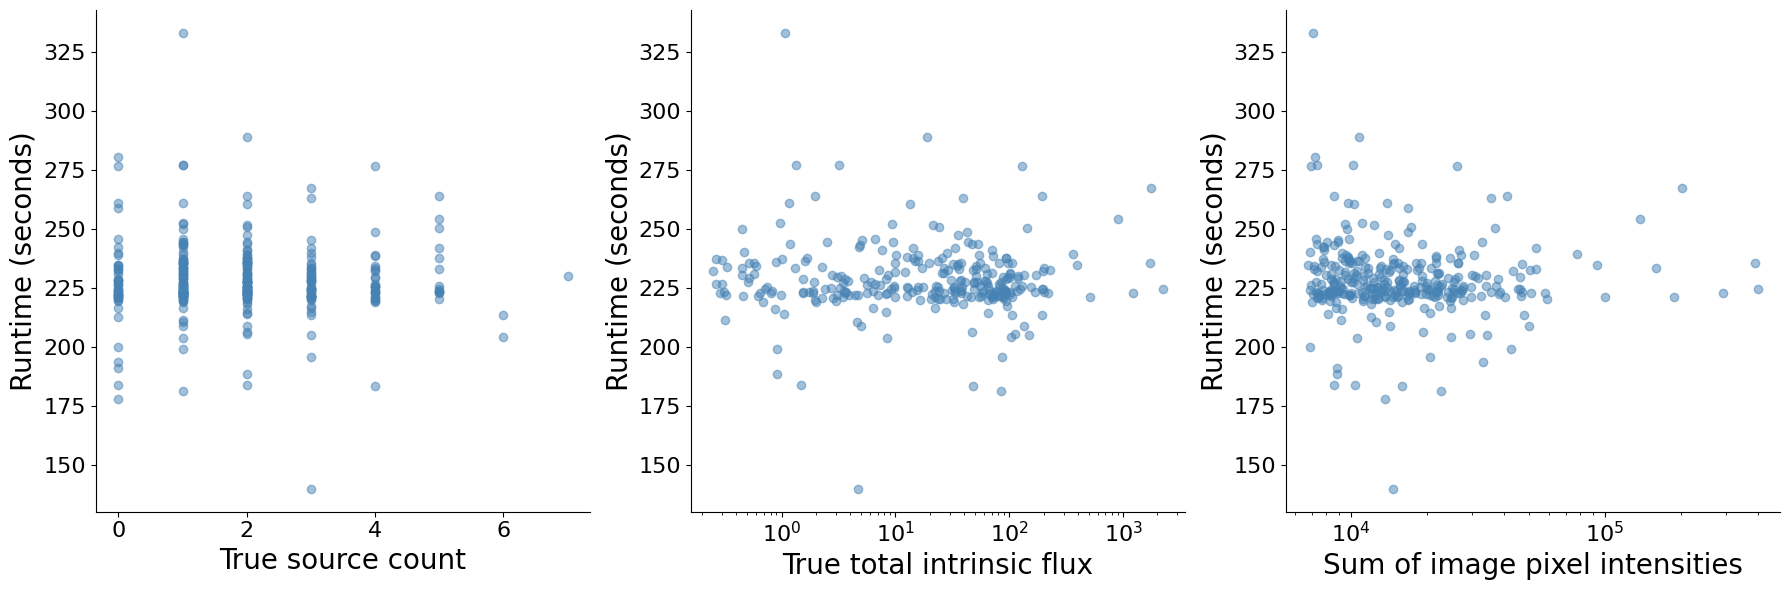

In [31]:
fig, ax = plt.subplots(1, 3, figsize = (18, 6))

_ = ax[0].scatter(pruned_counts, mcmc_runtime, color = mcmc_color, marker = mcmc_marker, alpha = 0.5)
_ = ax[0].set_xlabel("True source count", fontsize = bigfont)
_ = ax[0].set_ylabel("Runtime (seconds)", fontsize = bigfont)
_ = ax[0].tick_params(axis = "both", labelsize = mediumfont)
_ = ax[0].spines[['top', 'right']].set_visible(False)

_ = ax[1].scatter(pruned_fluxes.sum(-1), mcmc_runtime, color = mcmc_color, marker = mcmc_marker, alpha = 0.5)
_ = ax[1].set_xscale('log')
_ = ax[1].set_xlabel("True total intrinsic flux", fontsize = bigfont)
_ = ax[1].set_ylabel("Runtime (seconds)", fontsize = bigfont)
_ = ax[1].tick_params(axis = "both", labelsize = mediumfont)
_ = ax[1].spines[['top', 'right']].set_visible(False)

_ = ax[2].scatter(images.flatten(1,2).sum(-1), mcmc_runtime, color = mcmc_color, marker = mcmc_marker, alpha = 0.5)
_ = ax[2].set_xscale('log')
_ = ax[2].set_xlabel("Sum of image pixel intensities", fontsize = bigfont)
_ = ax[2].set_ylabel("Runtime (seconds)", fontsize = bigfont)
_ = ax[2].tick_params(axis = "both", labelsize = mediumfont)
_ = ax[2].spines[['top', 'right']].set_visible(False)

fig.tight_layout()

#fig.savefig('figures/m71_runtime.png', dpi = 250, transparent = True, bbox_inches = 'tight', pad_inches = 0)

---